<a href="https://colab.research.google.com/github/SpandanM110/Fellowship-Task/blob/main/Fellowship_ai_Task_NLP_SPANDAN_MUKHERJEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
df = pd.read_csv('/content/IMDB.csv')

In [ ]:
# Cleaning of the data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['review'] = df['review'].apply(clean_text)

In [ ]:
# Tokenization, stopwords removal, and lemmatization
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['review'] = df['review'].apply(preprocess_text)

#Split of Dataset

In [ ]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert sentiment labels to binary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Training of Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 88.69%


# Model Evaluation

In [ ]:
from sklearn.metrics import classification_report

# Print detailed classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Improving Model Accuracy with LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenization and padding the sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding the sequences
max_length = 200  # You can adjust this depending on average review length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [ ]:

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 416ms/step - accuracy: 0.7654 - loss: 0.4833 - val_accuracy: 0.8688 - val_loss: 0.3396
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 407ms/step - accuracy: 0.8684 - loss: 0.3230 - val_accuracy: 0.8794 - val_loss: 0.2933
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 412ms/step - accuracy: 0.9012 - loss: 0.2574 - val_accuracy: 0.8836 - val_loss: 0.2818
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 409ms/step - accuracy: 0.9142 - loss: 0.2248 - val_accuracy: 0.8813 - val_loss: 0.2911
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 446ms/step - accuracy: 0.9216 - loss: 0.2042 - val_accuracy: 0.8824 - val_loss: 0.2994


In [ ]:
# Evaluate the model
accuracy = model.evaluate(X_test_pad, y_test)[1]
print(f'LSTM Model Accuracy: {accuracy * 100:.2f}%')


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8858 - loss: 0.2926
LSTM Model Accuracy: 88.24%


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}

# Set up GridSearchCV
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

# Evaluate the best model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_tfidf)
accuracy_best = accuracy_score(y_test, y_pred_best)

print(f'Best Logistic Regression Accuracy: {accuracy_best * 100:.2f}%')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Logistic Regression Accuracy: 88.68%


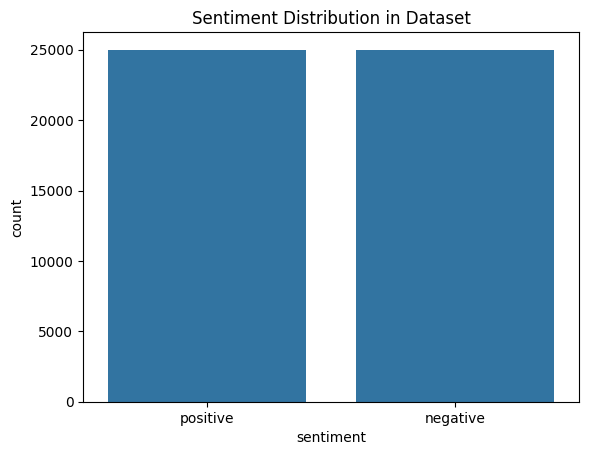

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution in Dataset')
plt.show()


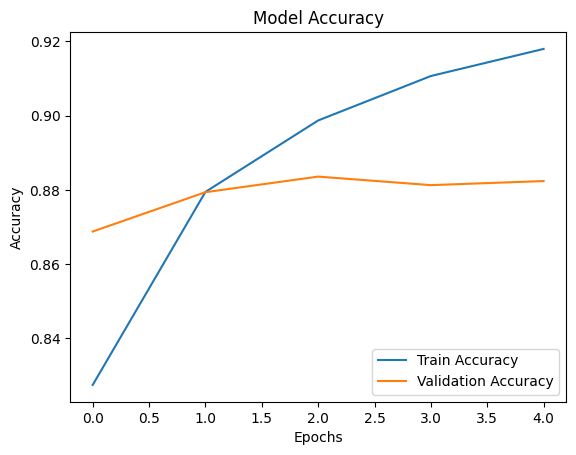

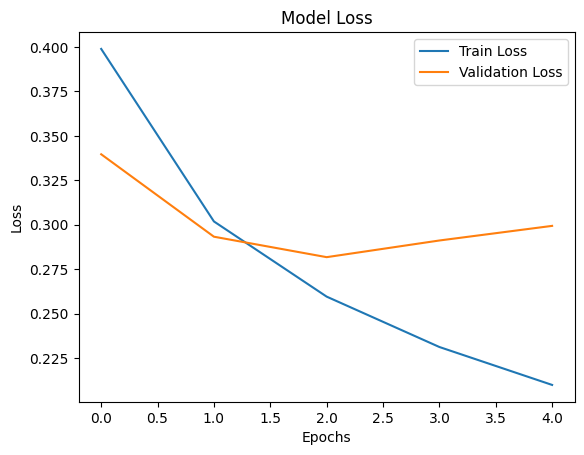

In [ ]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()


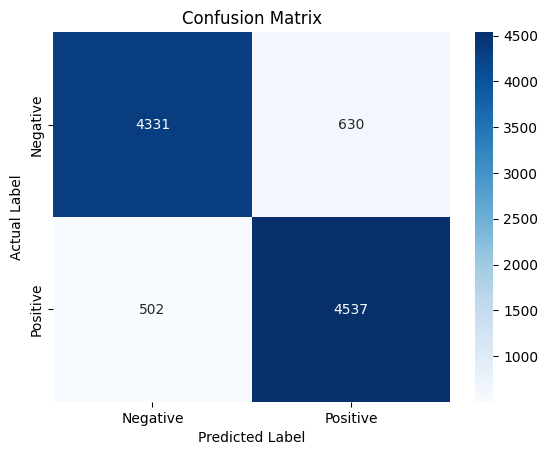

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


# ROC Curve

The ROC curve is useful to visualize the trade-off between the true positive rate (TPR) and false positive rate (FPR).

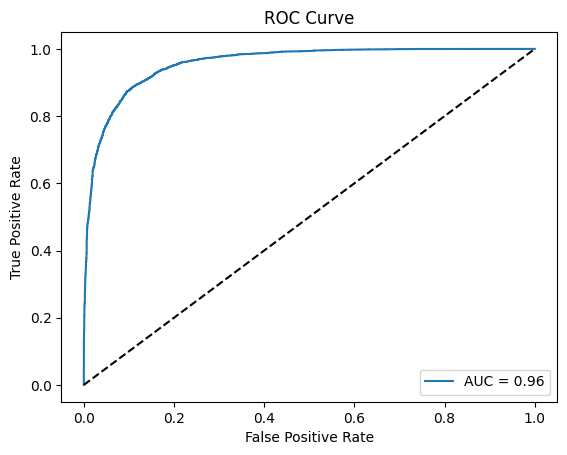

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = best_model.predict_proba(X_test_tfidf)[:,1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


Summary of Improvements:

LSTM Model: To improve accuracy by using an LSTM model for sentiment analysis.

Hyperparameter Tuning: Fine-tune hyperparameters with GridSearchCV to improve simpler models like Logistic Regression.

Visualization: Using graphs like sentiment distribution, accuracy and loss curves, confusion matrix, and ROC curves to gain better insights into model performance.